In [167]:
%load_ext autoreload
%autoreload 2

from newspaper import Article
import newspaper
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import openai
import random
from sklearn.cluster import DBSCAN, KMeans
from datetime import datetime as dt 
import datetime

# import local modules
from utils import *

!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter serverextension enable voila --sys-prefix

import ipywidgets as widgets
from IPython.display import display, clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Enabling: voila
- Writing config: /home/murnanedaniel/miniconda3/envs/topicDetect/etc/jupyter
    - Validating...
      voila 0.3.3 OK


# Topic Detection

## Roadmap

1. Load some articles
2. Cluster in space
3. Identify a cluster C 
4. Identify the topic T of C
5. Search for other articles with the same topic T using Google API
6. Get the summaries of all these articles
7. Re-cluster the full topic T
8. For each day of the articles, build two clusters, representing perspectives P1 and P2
9. Get representative articles for each perspective PA1 and PA2

### Authenticate

In [16]:
open_api_key = widgets.Text(placeholder='Enter your OpenAI API key here', description='OpenAI API key', value=None)
google_api_key = widgets.Text(placeholder='Enter your Google API key here', description='Google API key', value=None)

In [17]:
open_api_key

Text(value='', description='OpenAI API key', placeholder='Enter your OpenAI API key here')

In [18]:
google_api_key

Text(value='', description='Google API key', placeholder='Enter your Google API key here')

In [19]:
# button to run authentication
auth_button = widgets.Button(description="Run",
tooltip="Run authentication"
)
auth_output = widgets.Output()

# authentication function when button is clicked
def auth_button_clicked(b):
    with auth_output:
        openai.api_key = open_api_key.value
        google_api_key.value
        print("Authenticated")

auth_button.on_click(auth_button_clicked)
auth_result = widgets.VBox([auth_button, auth_output])

In [20]:
auth_result

## Build Article List

In [26]:
seed_topic = widgets.Text(placeholder='Enter a seed topic here', description='Seed topic', value="Ukraine")
seed_topic

Text(value='Ukraine', description='Seed topic', placeholder='Enter a seed topic here')

In [50]:
topic_button = widgets.Button(description="Build topic", tooltip="Run topic builder")
topic_output = widgets.Output()

def topic_button_clicked(b):
    with topic_output:
        global sample_articles, seed_articles

        seed_search_results = get_news_results(seed_topic.value, google_api_key.value, recency=14)
        seed_search_results = [result["link"] for result in random.sample(seed_search_results, 10)]
        seed_articles = [Article(url) for url in seed_search_results]

        smh_paper = newspaper.build('https://www.smh.com.au', memoize_articles=False)
        num_random = 30
        random_articles = smh_paper.articles[:num_random]
        
        sample_articles = seed_articles + random_articles

        sample_articles = parse_articles(sample_articles)
        sample_articles = interpret_articles(sample_articles)
        sample_articles = interpret_articles(sample_articles)

        print("Found initially {} articles".format(len(sample_articles)))

topic_button.on_click(topic_button_clicked)
topic_result = widgets.VBox([topic_button, topic_output])

Build the topic list (this may take a minute)

In [51]:
topic_result

In [124]:
embedding_button = widgets.Button(description="Build embeddings", tooltip="Run embedding builder")
embedding_output = widgets.Output()

def embedding_button_clicked(b):
    with embedding_output:
        global article_embeddings, X, articles2d, pca, embedding_ax, embedding_fig
        article_embeddings = embed_articles(sample_articles)
        X = np.stack(article_embeddings)
        print("Stacked")
        pca = PCA(n_components=2)
        articles2d = pca.fit_transform(X)
        print("Found {} articles".format(len(articles2d)))

        for article in articles2d[:len(seed_articles)]:
            embedding_ax.scatter(article[0], article[1], s=100, c="r")
        for article in articles2d[len(seed_articles):]:
            embedding_ax.scatter(article[0], article[1], s=100, c="k")

        print("Plotted")

embedding_button.on_click(embedding_button_clicked)
embedding_result = widgets.VBox([embedding_button, embedding_output])

We want to embed our sample articles into a high-dimensional space with GPT-3

In [125]:
embedding_result

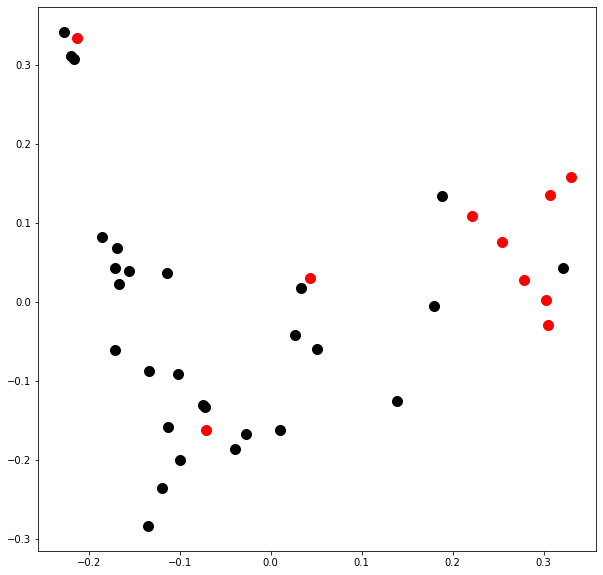

In [126]:
embedding_fig, embedding_ax = plt.subplots(figsize=(10,10))

## Visualize

## Predict Clusters

In [153]:
cluster_button = widgets.Button(description="Predict cluster", tooltip="Run clustering")
cluster_output = widgets.Output()

def cluster_button_clicked(b):
    with cluster_output:
        global db, kmeans, labels, cluster_ax, cluster_fig, cluster_topics, cluster_label
        num_clusters = 0
        eps = 0.6
        while num_clusters < 1:
            db = DBSCAN(eps=eps, min_samples=3).fit(X)
            labels = db.labels_
            num_clusters = len(np.unique(labels))-1
            eps += 0.05
        print("Found {} clusters".format(len(set(labels))))

        cluster_titles = ". ".join([article.title for article in sample_articles if db.labels_[sample_articles.index(article)] == 0])
        topic = get_topic(cluster_titles, "text-davinci-002")
        cluster_label = topic["choices"][0]["text"].replace("\n", "")

        cluster_topics = []
        for label in np.unique(db.labels_)[1:]:
            cluster_titles = ". ".join([article.title for article in sample_articles if db.labels_[sample_articles.index(article)] == label])
            topic = get_topic(cluster_titles, "text-davinci-002")
            cluster_topics.append(topic["choices"][0]["text"].replace("\n", ""))

        noise_article_list = articles2d[db.labels_ == -1]
        cluster_ax.scatter(noise_article_list[:, 0], noise_article_list[:, 1], s=30, c="k")

        for label, topic in zip(np.unique(db.labels_)[1:], cluster_topics):
            article_list = articles2d[db.labels_ == label]
            cluster_ax.scatter(article_list[:, 0], article_list[:, 1], s=100)
            # Plot cluster_label text in center of cluster
            cluster_ax.text(article_list[:, 0].mean(), article_list[:, 1].mean(), cluster_label, fontsize=20)
            # Draw a circle around all points in article_list
            circle_center = article_list[:, 0].mean(), article_list[:, 1].mean()
            distances_from_mean = np.sqrt(np.sum((article_list - circle_center)**2, axis=1))
            circle_radius = distances_from_mean.max() * 1.2
            cluster_ax.add_patch(plt.Circle((article_list[:, 0].mean(), article_list[:, 1].mean()), radius=circle_radius, alpha=0.2))

        print("Finished plotting!")

cluster_button.on_click(cluster_button_clicked)
cluster_result = widgets.VBox([cluster_button, cluster_output])

## Get Topic of Cluster

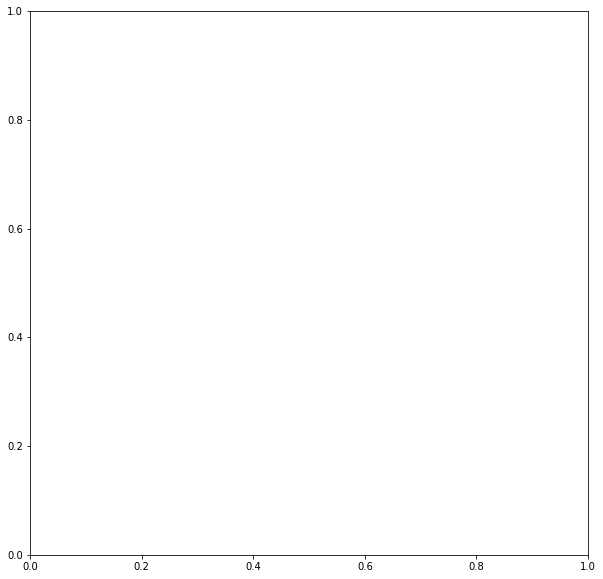

In [108]:
cluster_fig, cluster_ax = plt.subplots(figsize=(10,10))

In [109]:
cluster_result

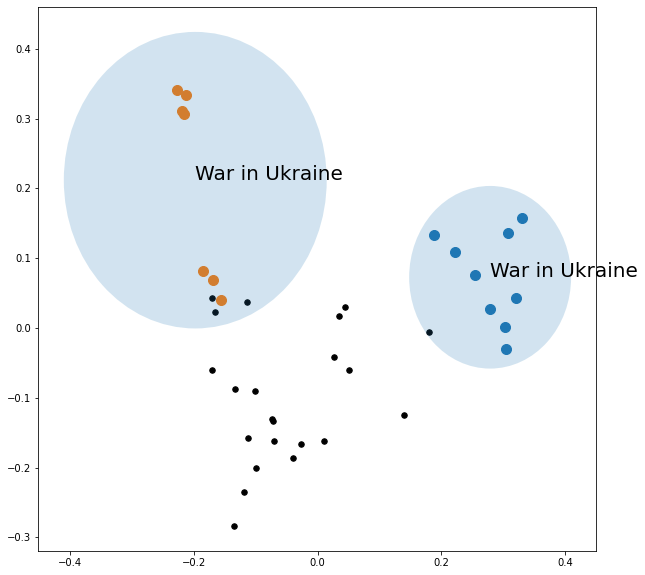

In [105]:
cluster_fig

## Find Related Articles

Let's focus on the blue cluster, and find some more articles about it.

In [118]:
related_button = widgets.Button(description="Get related articles", tooltip="Run search")
related_output = widgets.Output()

def related_button_clicked(b):
    with related_output:
        global cluster_topic, all_articles, related_news_articles
        cluster_topic = cluster_topics[0]
        print(f"Let's focus on the first cluster topic: {cluster_topic}")

        cluster_articles = [article for article in sample_articles if db.labels_[sample_articles.index(article)] == 0]
        # Aggregate all article keywords
        cluster_keyword_list = [article.keywords for article in cluster_articles]

        # Flatten list of lists
        cluster_keyword_list = [keyword for sublist in cluster_keyword_list for keyword in sublist]

        recency = 60
        related_news_results = get_news_results(cluster_label, google_api_key.value, recency=recency)
        print(f"Found {len(related_news_results)} related news results")

        # Make Article list from related_news_results
        related_news_articles = [Article(related_news_result["link"]) for related_news_result in related_news_results]

        # Parse and interpret articles
        related_news_articles = parse_articles(related_news_articles)
        related_news_articles = interpret_articles(related_news_articles)

        all_articles = sample_articles + related_news_articles

related_button.on_click(related_button_clicked)
related_result = widgets.VBox([related_button, related_output])

In [119]:
related_result

Now, we re-cluster the full topic and this will form the basis of our Storyline:

In [154]:
recluster_button = widgets.Button(description="Re-cluster with related articles", tooltip="Run re-cluster")
recluster_output = widgets.Output()

def recluster_button_clicked(b):
    with recluster_output:
        global storyline_articles, recluster_ax, pca
        average_article_summary_length = np.mean([len(article.summary.split(" ")) for article in related_news_articles])
        print(f"We need to be a little careful with using GPT-3. We will be embedding {len(related_news_articles)} articles, and the average article summary length is {average_article_summary_length:,.2f} tokens.")
        print(f"The engine we are using costs ~1c per 1k tokens, therefore {len(related_news_articles)} articles will cost ~${len(related_news_articles) * average_article_summary_length / 1000 / 100:,.2f}. I.e. Don't run this step for fun!")

        # Embed articles
        related_news_embeddings = embed_articles(related_news_articles)
        
        # Visualise in PCA related embeddings
        related_news_embeddings = np.stack(related_news_embeddings)
        related_articles2d = pca.transform(related_news_embeddings)
        
        recluster_ax.scatter(articles2d[:len(seed_articles), 0], articles2d[:len(seed_articles), 1], s=100, c="b", label=cluster_topic)
        recluster_ax.scatter(articles2d[len(seed_articles):, 0], articles2d[len(seed_articles):, 1], s=30, c="k", label="Unrelated Articles")
        recluster_ax.scatter(related_articles2d[:, 0], related_articles2d[:, 1], s=100, c="r", label="Related Articles")
        recluster_ax.legend()

        new_articles_embedding = np.concatenate([X, related_news_embeddings])

        pca = PCA(n_components=2)
        new_articles2d = pca.fit_transform(new_articles_embedding)

        num_clusters = 0
        eps = 0.6
        while num_clusters < 1:
            new_clustering = DBSCAN(eps=eps, min_samples=3).fit(new_articles_embedding)
            num_clusters = len(np.unique(new_clustering.labels_)) -1
            eps += 0.05
        print(f"Found {num_clusters} clusters")

        for label in np.unique(db.labels_):
            article_list = new_articles2d[new_clustering.labels_ == label]
            recluster_ax.scatter(article_list[:, 0], article_list[:, 1], s=100)

        overlap_labels = new_clustering.labels_[:len(db.labels_)][db.labels_ == 0]
        overlap_labels = overlap_labels[overlap_labels != -1]
        most_overlap_cluster = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=overlap_labels)
        print(f"The most overlapping cluster is {most_overlap_cluster}")

        all_articles_dict = [article.__dict__ for article in all_articles]

        for i, article in enumerate(all_articles_dict):
            article["embedding"] = new_articles_embedding[i]
            article["2d"] = new_articles2d[i]

        storyline_articles = [article for article in all_articles_dict if new_clustering.labels_[all_articles_dict.index(article)] == most_overlap_cluster]

        # Remove storyline articles that don't have a publish date
        storyline_articles = [article for article in storyline_articles if article["publish_date"] is not None]
        print(f"Found {len(storyline_articles)} storyline articles")

recluster_button.on_click(recluster_button_clicked)
recluster_result = widgets.VBox([recluster_button, recluster_output])

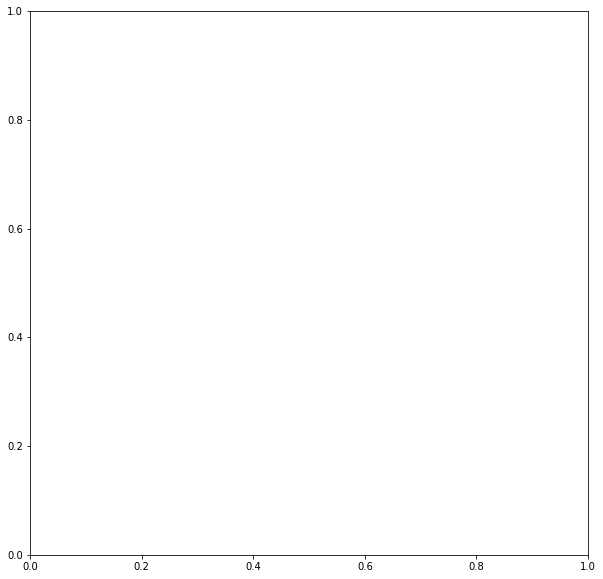

In [155]:
recluster_fig, recluster_ax = plt.subplots(figsize=(10,10))

In [158]:
recluster_result

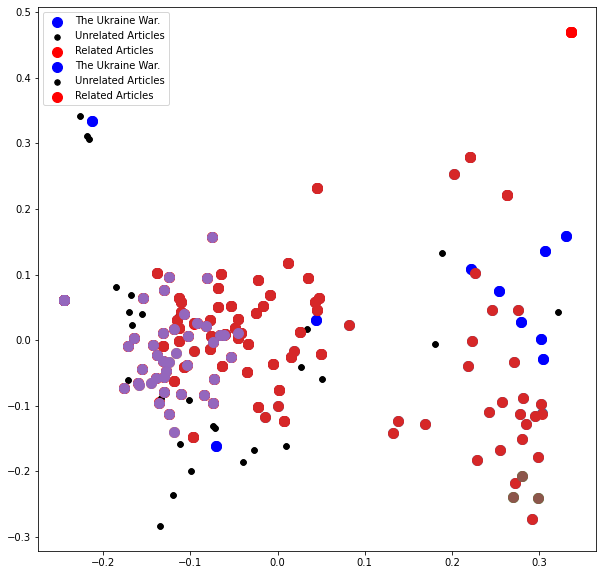

In [157]:
recluster_fig

Now we have a full set of well-clustered and well-populated articles on a topic. This is our "Storyline". Now we need to process it for easy consumption. Let's create a "view" of the latest week, and see which articles are most representative of two competing viewpoints.

In [192]:
weekview_button = widgets.Button(description="Represent Weekview", tooltip="Run week representation")
weekview_output = widgets.Output()

    
def weekview_button_clicked(b):
    with weekview_output:
        global storyline_articles, weekview_ax, weekview_fig, weekview_articles, weekview_embeddings, weekview_2d, comparison
        for article in storyline_articles:
            article["publish_date"] = article["publish_date"].replace(tzinfo=None)
        storyline_articles = sorted(storyline_articles, key=lambda x: x["publish_date"])

        week_start = dt.now() - datetime.timedelta(days=7)
        week_end = dt.now()
        weekview_articles = [article for article in storyline_articles if article["publish_date"] >= week_start and article["publish_date"] <= week_end]

        weekview_embeddings = [article["embedding"] for article in weekview_articles]
        weekview2d = pca.transform(weekview_embeddings)
        weekview_embeddings = np.stack(weekview_embeddings)
        weekview_clustering = KMeans(n_clusters=2).fit(weekview_embeddings)

        # Plot the weekview 2d embeddings
        fig, ax = plt.subplots(figsize=(10,10))
        for label in np.unique(weekview_clustering.labels_):
            article_list = weekview2d[weekview_clustering.labels_ == label]
            ax.scatter(article_list[:, 0], article_list[:, 1], s=100, label=label)
        ax.legend( loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
        ax.set_title(f"Weekview of {cluster_topic}, for two different perspectives")

        cluster0_mean = weekview_embeddings[weekview_clustering.labels_ == 0].mean(axis=0)
        cluster0_distances = np.sqrt(np.sum((weekview_embeddings - cluster0_mean)**2, axis=1))
        cluster0_representative_article = weekview_articles[np.argmin(cluster0_distances)]

        cluster0_representative_article = get_representative(weekview_embeddings, weekview_clustering.labels_, weekview_articles, 0)
        cluster1_representative_article = get_representative(weekview_embeddings, weekview_clustering.labels_, weekview_articles, 1)

        print("The two representative articles are:")
        print(cluster0_representative_article["source_url"])
        print(cluster1_representative_article["source_url"])

        comparison = get_comparison(cluster0_representative_article, cluster1_representative_article)["choices"][0]["text"].replace("\n", "")
        print(f"This is the comparison we get from GPT-3: \n\n{comparison}")
    
weekview_button.on_click(weekview_button_clicked)
# Make VBox with width 100px
weekview_result = widgets.HBox([widgets.VBox([weekview_button, weekview_output], layout=widgets.Layout(width="100%"))])

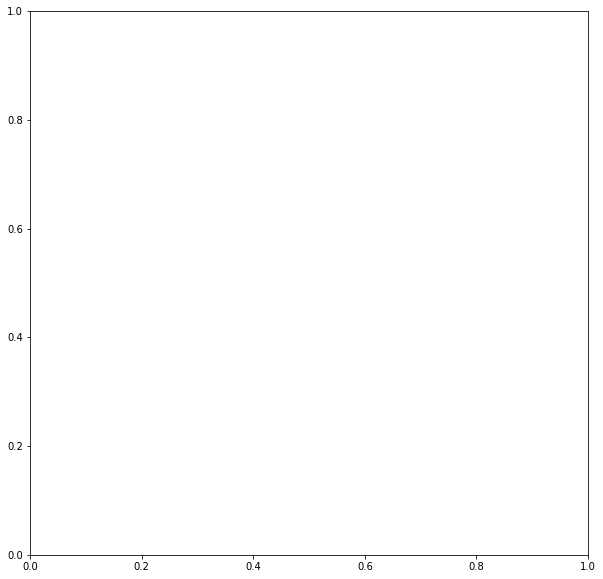

In [193]:
weekview_ax, weekview_fig = plt.subplots(figsize=(10,10))

In [194]:
weekview_result